# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name=r'C:\Users\Aaron\Documents\GitHub\deep-reinforcement-learning\p1_navigation\VisualBanana_Windows_x86_64\Banana.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# check if GPU is available
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


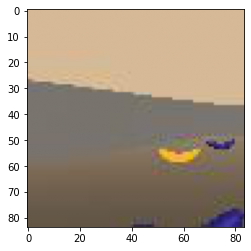

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### Model
This QNetwork will later be used as the "q-table".\
    The input to the network is state\
    The output is the q values associate with the 4 action of the agent

Side note->\
one of the lessons I learned here is that I should use leacky relu:\
"Usually there isn’t that much of a problem of overfitting in RL due to state space. Ratherly, ‘dying’ neurons are more of an issue than overfitting, hence the success of strategies that utilise leaky linear rectified units (Leaky ReLU)"\
https://www.quora.com/Why-is-a-dropout-not-used-for-deep-reinforcement-learning-such-as-DQN-DDPG-etc

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, action_size, seed, fc1_units=256, fc2_units=64, fc3_units=8):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)                     # using identical seed for both target and online model
        self.model_transfer = models.resnet18(pretrained=True)  # define resnet model
        # Freeze training for all transfered layer
        for param in self.model_transfer.parameters():
            param.requires_grad = False
        # overwrite the fully connected layer
        self.model_transfer.fc = nn.Sequential(
            nn.Linear(512, fc1_units), nn.LeakyReLU(0.1),       # leady relu to prevent relu die
            nn.Linear(fc1_units, fc2_units), nn.ReLU(), 
            nn.Linear(fc2_units, fc3_units), nn.ReLU(), 
            nn.Linear(fc3_units, action_size)
       )


    def forward(self, state):
        """Build a network that maps state -> action values."""
        return self.model_transfer(state)

#### The structure of the network
I tried to build my own CNN, but the structure is too big to train on a personal laptop. So, I used a transfered model.

In [6]:
qnetwork = QNetwork(action_size = 4, seed = 0).to(device) 
print(qnetwork) #show the struction of the network

QNetwork(
  (model_transfer): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

### Agent

In [7]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e4)  # replay buffer size
min_buffer_size2learn = 300 # minimum buffer size of samples for agent to start learning
BATCH_SIZE = 30         # minibatch size
GAMMA = 0.99            # discount factor, refer to P1_navigation/Reference/thrun_sebastian_1993_1
TAU = 1e-3              # for soft update of target parameters(use for dueling DDQN to increase the sample efficiency)
LR = 7e-4               # learning rate, the GDRL book said that the learning rate need to be small to stablize the network
UPDATE_EVERY = 4        # how often to update the network, I tried 10 and 4. seems the bigger the network to bigger this number


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(action_size, seed).to(device) #setup the online training network with a fixed seed
        self.qnetwork_target = QNetwork(action_size, seed).to(device)#setup the target training network with the same fixed seed
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.qnetwork_local.parameters()), lr=LR)
        self.max_gradient_norm = float('inf') #by default setting inf will have the optimizer to be normal mse
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        
        self.memory.add(state, action, reward, next_state, done) # Save experience in replay memory
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY   # Learn every UPDATE_EVERY time steps.
        if self.t_step == 0:                             # check if its time to update the network
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > min_buffer_size2learn: # check if the buffer size is big enough to sample
                experiences = self.memory.sample()       # take a random sample batch from the buffer
                self.learn(experiences, GAMMA)           # train the network with the sample

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # --- find the action values of the current state for the following q-learning algorithm --- #   
        self.qnetwork_local.eval()                     # set the online work to evaluation mode and shutoff the dropoff
        with torch.no_grad():                          # disabled gradient calculation cuz we don't need to backpropagation here
            action_values = self.qnetwork_local(state) # find the action values for the current state
        self.qnetwork_local.train()                    # return the online network to the training mode
        
        #------- Exploration strategies(we used the epsilon-greedy)-------#
        # Epsilon-greedy action selection, refer to P1_navigation/Reference/thrun_sebastian_1993_1 and GDRL chapter9
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()) # use the action that has the max qvalue for current state
        else: # in the begining, we might want to randomly choose some actions to explore more than exploit
            return random.choice(np.arange(self.action_size)) 

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences            # generate the experience tuple
        
        # ------------ Regular DQN(has commented out) --------------- #   
        # DQN Get max predicted Q values (for next states) from target model
        #maxQ_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # ----------------------- Double DQN ------------------------- #       
        # DDQN Get max predicted Q values (for next states) from target model
        maxQ_action = self.qnetwork_local(next_states).max(1)[1] # get the best action for the next states w/ highest Q value
        Q_targets_next = self.qnetwork_target(next_states).detach() # get all the q values for all the actions of the next state
        maxQ_targets_next = Q_targets_next[np.arange(BATCH_SIZE), maxQ_action].unsqueeze(1) # find the max qvalues
        
        # ------------------- q-learning algorithm ------------------- #
        Q_targets = rewards + (gamma * maxQ_targets_next * (1 - dones))        # Compute Q targets for current states 
        Q_expected = self.qnetwork_local(states).gather(1, actions)            # Get expected Q values from local model
        loss = F.mse_loss(Q_expected, Q_targets)                               # Compute loss
        self.optimizer.zero_grad()                                             # Minimize the loss
        loss.backward()                                                        # backpropagation
        
        # ------------------------ Huber loss ------------------------ #
        #refer to Chapter 9 of the GDRL book Page303 for Huber loss. currently set max_gradient_norm=inf as regular MSE
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), self.max_gradient_norm)
        self.optimizer.step()                                                  # update the weights
        
        # --- update target network using Dueling(refer to GDRL chapter 10)-- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

##----------------------------------Dueling DQN------------------------------------##
    def soft_update(self, local_model, target_model, tau): 
        """Soft update model parameters. Refere to GDRL, chapter 10
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.model_transfer.fc.parameters(), # here I made sure only update the
                                             local_model.model_transfer.fc.parameters()): # untrained fully connected layers
            # balance some portion of online learning to the target network
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data) 

### Replay Buffer
This buffer store the past experiences = list of tuples(states, actions, rewards, next_states, dones)\
These experiences are used to train the online network.
1. During the agent training, the agent will step(self, state, action, reward, next_state, done) to add new experience to the Replay Buffer.
2. Meanwhile, the agent.learn(self, experiences, gamma) function will use ReplayBuffer.sample(self) to generate a small train batch from the Replay Buffer if there is enough experiences in the Buffer at the right learning time.

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size 
        self.memory = deque(maxlen=buffer_size)                     # generate a queue to store the experiences tuples
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    #------------------------------- Add a new experience to memory--------------------------------#
    def add(self, state, action, reward, next_state, done):
        """setter function to save new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)                                       # add the experience to queue
        
    #---------------------- Randomly sample a batch of experiences from memory --------------------#
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size) # randomly pick some of the experience from the buffer
        # conver the experiences to tensors for training:
        states = torch.cat([e.state for e in experiences if e is not None], dim=0).to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.cat([e.next_state for e in experiences if e is not None], dim=0).to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### set up the learning agent
#### about Huber Hyperparameter Selection:
The below link said --- "𝛿 = 1 represented MAE quite accurately, while 𝛿 = 3 tends to go towards MSE already. What if you used 𝛿 = 1.5 instead? You may benefit from both worlds". ->\
https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/ <br/>I used 1.35 shown in the code block to set up the learning agent, the hyperparameter (delta) was choose base on this link ->\
https://stats.stackexchange.com/questions/465937/how-to-choose-delta-parameter-in-huber-loss-function/473767 <br/>The mentor advice this a website that also recommend 𝛿 = 1.5-><br/>
https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3

In [9]:
agent = Agent(action_size=4, seed=0)   #set up the learning agent
agent.max_gradient_norm = 1.35         #set the loss function with Huber

### Train
some references to solve the training problems:<br />
https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn<br />
http://theorangeduck.com/page/neural-network-not-working#batchsize<br />

#### State preprocess helper Function
Function that normalized the input state and convert that to tensor. In the end, I generated some sample images for me to check if the inputs make sense in regards to the clearity.

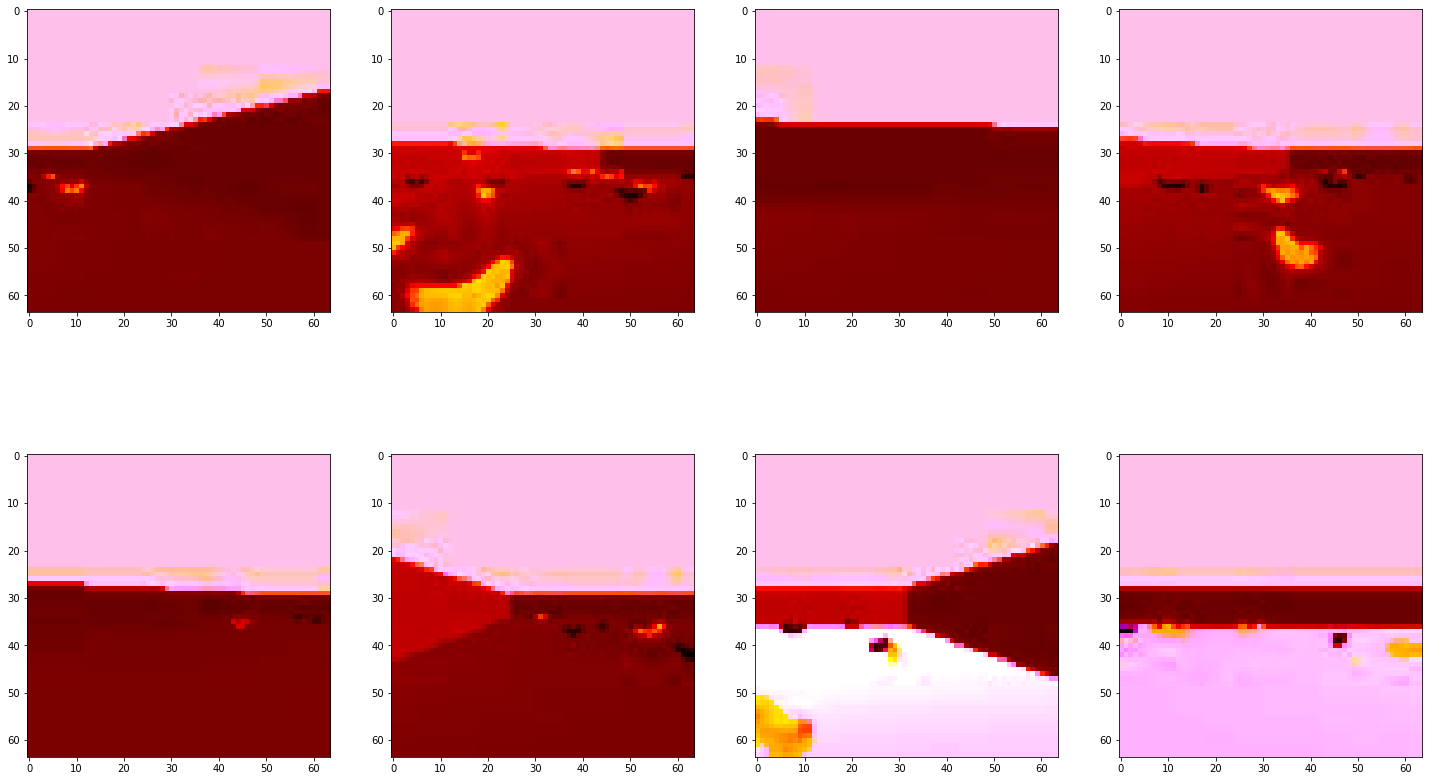

In [10]:
# Helper function to process the input state
from PIL import Image
import torchvision.transforms as transforms

#-------------------------function that convert the input state from np.array to tensor---------------------#
def state2tensor(state):
    data_transform = transforms.Compose([
        transforms.Resize(64), # reshape the size to resnet input size which is 64x64x3 tensor
        transforms.ToTensor(), # convert the RGB image type to tensor
        transforms.Normalize(mean=[0.1, 0.5, 0.5], std=[0.5, 0.3, 0.1]) # normalize data
    ])
    new_im = Image.fromarray(np.uint8(np.squeeze(state)*255),'RGB') #convert a numpy array to image type
    img_tensor = data_transform(new_im).unsqueeze(dim=0) #change image size for Resnet18 input reqirement
    state_tensor = img_tensor.to(device) #send the tensor to GPU if available
    return state_tensor

#---------show some examples of the input image, we can see it is clear enough for this application---------#
fig=plt.figure(figsize=(25, 15))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)                # setup plot layout
    env_info = env.reset(train_mode=True)[brain_name]# reset the environment
    action = np.random.randint(action_size)          # select an random action
    env_info = env.step(action)[brain_name]          # send the action to the environment
    state = env_info.visual_observations[0]          # get the next state
    tensor_image = state2tensor(state).squeeze(0).to('cpu')
    plt.imshow(tensor_image.permute(1, 2, 0))
plt.show()

#### Training function
This function is use to train the agent. In each episode, the agent will explore from one state to another to collect rewards.\
The agent will train itself to be able to get more scores during the preset time limit for each episode.<br/>
\
The goad:\
The agent's average score of last 100 episodes >= 13\
\
The rule:
1. Yellow banana +1
2. Blue banana -1<br/>

In [13]:
def dqn(n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.996): #eps will decay to 0.01 around 1000
                                                                  #refer to P1_navigation/Reference/thrun_sebastian_1993_1 
                                                                  #for more information about eps
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                                                 # list containing scores from each episode
    scores_window = deque(maxlen=100)                           # last 100 scores
    eps = eps_start                                             # initialize epsilon
    
    #--------------------------------------run the episodes--------------------------------------------#
    for i_episode in range(1, n_episodes+1):                    # iterate through each episode(each episode contain many states)
        """replay the envirment, and get the starting state. convert the starting state of each episode to tensor"""
        env_info = env.reset(train_mode=False)[brain_name]      # reset the environment
        state = state2tensor(env_info.visual_observations[0])   # get the current state
        
        #--------------step the agent from one state to another, during each episode-------------------#
        score = 0
        for t in range(max_t):                                  # step the agent from one state to another, during each episode
            """get the next state base on agent's action"""
            action = agent.act(state, eps).astype(int)          #search the agents DQN to get the next move
            env_info = env.step(action)[brain_name]             # send the action to the environment
            reward = env_info.rewards[0]                        # get the reward
            next_state = state2tensor(env_info.visual_observations[0])# get the next state
            done = env_info.local_done[0]                       # see if episode has finished
            """send the new experience to agent for learning"""
            agent.step(state, action, reward, next_state, done) #move the agent to next position in the enviroment
            state = next_state                                  #update the state for the next step
            score += reward                                     #update the total rewards of each episode
            if done:
                break 

    #---------------------------process the scores and stop if goal reached----------------------------#
        scores_window.append(score)                             # save most recent 100 score to calculate the average
        scores.append(score)                                    # save most recent score
        eps = max(eps_end, eps_decay*eps)                       # decrease epsilon for next episode, so agent exploit more
        print('\rEpisode {}\tAverage Score: {:.2f} | recent 100 scores->'.format(i_episode, np.mean(scores_window)), end="")
        print(scores_window, end="")                            # print the recent 100 scores to check improvement
        if i_episode % 300 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'qnet_local_pixel.pth')
            torch.save(agent.qnetwork_target.state_dict(), 'qnet_target_pixel.pth')
        if np.mean(scores_window)>=13:                          # if the score >=13, we stop train and save the network for demo
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'qnet_local_pixel.pth')
            break
            
    return scores

#### start training
generate the scores history for each episode

In [ ]:
scores_huber = dqn() # start training

Episode 14	Average Score: -0.36 | recent 100 scores->deque([-1.0, 0.0, -1.0, -1.0, 0.0, 0.0, -2.0, -1.0, -1.0, 2.0, -1.0, -1.0, 2.0, 0.0], maxlen=100)

### Evaluate Data

#### CSV helper function
This function helps to store and read the scores from a csv file

In [ ]:
import csv

def writeCSV(filename, scores):
    # writing to csv file  
    with open(filename, 'a',newline='') as csvfile:  
        # creating a csv writer object  
        csvwriter = csv.writer(csvfile)
        for i, score in enumerate(scores):
            csvwriter.writerow([i, score])

def readCSV(filename):
    # opening the CSV file  
    with open(filename, mode ='r')as csvfile:  
        # reading the CSV file  
        csvreader = csv.reader(csvfile)  
        scores = []
        # displaying the contents of the CSV file  
        for lines in csvreader: 
            scores.append(float(lines[1]))
    return scores


In [ ]:
import os.path
if os.path.isfile("scores_Pixels.csv") == False:
    writeCSV("scores_Pixels.csv", scores_huber) #store the finished scores
    
import pandas as pd
scores = readCSV("scores_Pixels.csv")
scores_moving_average = pd.Series(scores).rolling(100).mean()
# plot the scores
fig = plt.figure(figsize=(15,10))

plt.plot(np.arange(len(scores_mse)), scores)
plt.plot(scores_moving_average, 'r', linewidth=4, alpha=0.5)
plt.axhline(13, c ='b', linewidth=1)
plt.legend(["score","mean","criteria"])

plt.rcParams.update({'font.size': 14}) #defind the font size
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Rewards vs. Episode')
plt.grid(which="major")
plt.show()

<img src="Image/report.JPG" style="width:800px;height:300px;">

### Watch a Smart Agent!

In [ ]:

# # load the weights from file
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# for i in range(5):
#     env_info = env.reset(train_mode=False)[brain_name]
#     state = env_info.vector_observations[0]   # get the next state
    
#     for j in range(200):
#         action = agent.act(state).astype(int)
#         env_info = env.step(action)[brain_name]
#         state = env_info.vector_observations[0]   # get the next state
#         done = env_info.local_done[0]             # see if episode has finished
#         if done:
#             break


When finished, you can close the environment.

In [ ]:
#env.close()